# Project 3
## Problem 4 - SDSS galaxies with sklearn

The data is provided in the file <b>"specz_data.txt"</b>. The columns of the file (length of 13) correspond to - <br>
spectroscopic redshift ('zspec'), RA, DEC, magnitudes in 5 bands - u, g, r, i, z (denoted as 'mu,' 'mg,' 'mr,' 'mi,' 'mz' respectively); Exponential and de Vaucouleurs model magnitude fits ('logExp' and 'logDev' http://www.sdss.org/dr12/algorithms/magnitudes/); zebra fit ('pz_zebra); Neural Network fit ('pz_NN') and its error estimate ('pz_NN_Err') <br>

We will undertake 2 exercises  -
- Regression
    - We will use the magnitude of object in different bands ('mu, mg, mr, mi, mz') and do a regression exercise to estimate the redshift of the object. Hence our feature space is 5.
    - The correct redshift is given by 'zspec', which is the spectroscopic redshift of the object. We will use this for training and testing purpose.
    
    Sidenote: Photometry vs. Spectroscopy
    
    <i>&nbsp; &nbsp; The amount of energy we receive from celestial objects – in the form of radiation – is called the flux, and an astro- nomical technique of measuring the flux is photometry. Flux is usually measured over broad wavelength bands, and with the estimate of the distance to an object, it can infer the object’s luminosity, temperature, size, etc. Usually light is passed through colored filters, and we measure the intensity of the filtered light.
    
    &nbsp; &nbsp; On the other hand, spectroscopy deals with the spectrum of the emitted light. This tells us what the object is made of, how it is moving, the pressure of the material in it, etc. Note that for faint objects making photometric observation is much easier.
    
    &nbsp; &nbsp; Photometric redshift (photoz) is an estimate of the distance to the object using photometry. Spectroscopic redshift observes the object’s spectral lines and measures their shifts due to the Doppler effect to infer the distance.</i>
    

- Classification
    - We will use the same magnitudes and now also the redshift of the object  ('zspec') to classify the object as either Elleptical or Spiral. Hence our feature space is now 6.
    - The correct class is given by compring 'logExp' and 'logDev' which are the fits for Exponential and Devocular profiles. If logExp > logDev, its a spiral and vice-versa. We will use this for training and testing purpose. Since the classes are not explicitly given, generate a column for those (Classes can be $\pm 1$. If it is $0$, it does not belong to either of the class.)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# -*- coding: utf-8 -*-
import numpy as np
#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

seed=12
np.random.seed(seed)
import sklearn

In [3]:
# Decorations :D
def canvas_ticks(obj):
    '''This provides ticks in to a blanck canvas, for singular plots
    use plt as the argumenet, for suplots, in for gridspec for expample
    insert ax1 as argument'''
    obj.minorticks_on()
    obj.tick_params(labelsize=14)
    obj.tick_params(labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    obj.tick_params(direction='in',which='minor', length=4, bottom=True, top=True, left=True, right=True)
    obj.tick_params(direction='in',which='major', length=8, bottom=True, top=True, left=True, right=True)

plt.style.use('default')
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
error_bar_settings = {
        'fmt': 'o',
        'ms': 7,
        # 'mfc': plot_color,
        'ecolor': 'black',
        'mec': 'black',
        'capsize': 2,
        'mew': 0.5,
        'elinewidth': .5,
        # 'alpha': 0.85,
    }
%config InlineBackend.figure_format = 'retina'


##### Cleaning

Read in the files to create the data (X and Y) for both regression and classification. <br>
You will have to clean the data -
- Drop the entries that are nan or infinite
- Drop the unrealistic numbers such as 999, -999; and magnitudes that are unrealistic. Since these are absolute magnitudes, they should be positive and high. Lets choose a magnitude limit of 15 as safe bet.
- For classification, drop the entries that do not belong to either of the class


In [4]:
#Read in and create data

fname = '/content/drive/My Drive/P188_288/P188_288_Project3/specz_data.txt'
spec_dat=np.genfromtxt(fname,names=True)
print(spec_dat.dtype.fields.keys())
#convenience variable
zspec = spec_dat['zspec']
pzNN = spec_dat['pz_NN']
#some N redshifts are not defined
pzNN[pzNN < 0] = np.nan

#For Regression
bands = ['u', 'g', 'r','i', 'z' ]
mlim = 15

xdata = np.concatenate([[spec_dat['m%s'%i] for i in bands]]).T
bad = (xdata[:, 0] < mlim) | (xdata[:, 1] < mlim) | (xdata[:, 2] < mlim) & (xdata[:, 3] < mlim) | (xdata[:, 4] < mlim)
xdata = xdata[~bad]
xdata[xdata<0] = 0
ydata = zspec[~bad]

#For classification
classes = np.sign(spec_dat['logExp'] - spec_dat['logDev'])
tmp = np.concatenate([[spec_dat['m%s'%i] for i in bands]]).T
xxdata = np.concatenate([tmp, zspec.reshape(-1, 1)], axis=1)
bad = (classes==0) | (xxdata[:, 0] < mlim) | (xxdata[:, 1] < mlim) | (xxdata[:, 2] < mlim) & (xxdata[:, 3] < mlim) | (xxdata[:, 4] < mlim)
xxdata = xxdata[~bad]
classes = classes[~bad]

dict_keys(['zspec', 'RA', 'DEC', 'mu', 'mg', 'mr', 'mi', 'mz', 'logExp', 'logDev', 'pz_zebra', 'pz_NN', 'pz_NN_Err'])


For regression, X and Y data (called "xdata" and "ydata," respectively) is cleaned magnitudes (5 feature space) and spectroscopic redshifts respectively.
For classification, X and Y data (called "xxdata" and "classes" respectively) is cleaned magnitudes+spectroscopic redshifts respectively (6 feature space) and classees respectively.

In [5]:
print('For Regression:')
print('Before: Size of datasets is ', zspec.shape[0])
print('After: Size of datasets is ', xdata.shape[0])
print('')
print('For Classification:')
print('Before: Size of datasets is ', zspec.shape[0])
print('After: Size of datasets is ', xxdata.shape[0])

For Regression:
Before: Size of datasets is  5338
After: Size of datasets is  4535

For Classification:
Before: Size of datasets is  5338
After: Size of datasets is  4147


##### Visualization

The next step should be to visualize the data. <br>
For regression
- Make a histogram for the distribution of the data (spectroscopic redshift).
- Make 5 2D histograms of the distribution of the magnitude as function of redshift (Hint: https://matplotlib.org/devdocs/api/_as_gen/matplotlib.axes.Axes.hist2d.html)

For classification <br>
- Make 6 1-d histogram for the distribution of the data (6 features - zspec and 5 magnitudes) for both class 1 and -1 separately

<span style="color:blue"> <i> 1. Make histograms for both regression and classification. </i></span> <br>

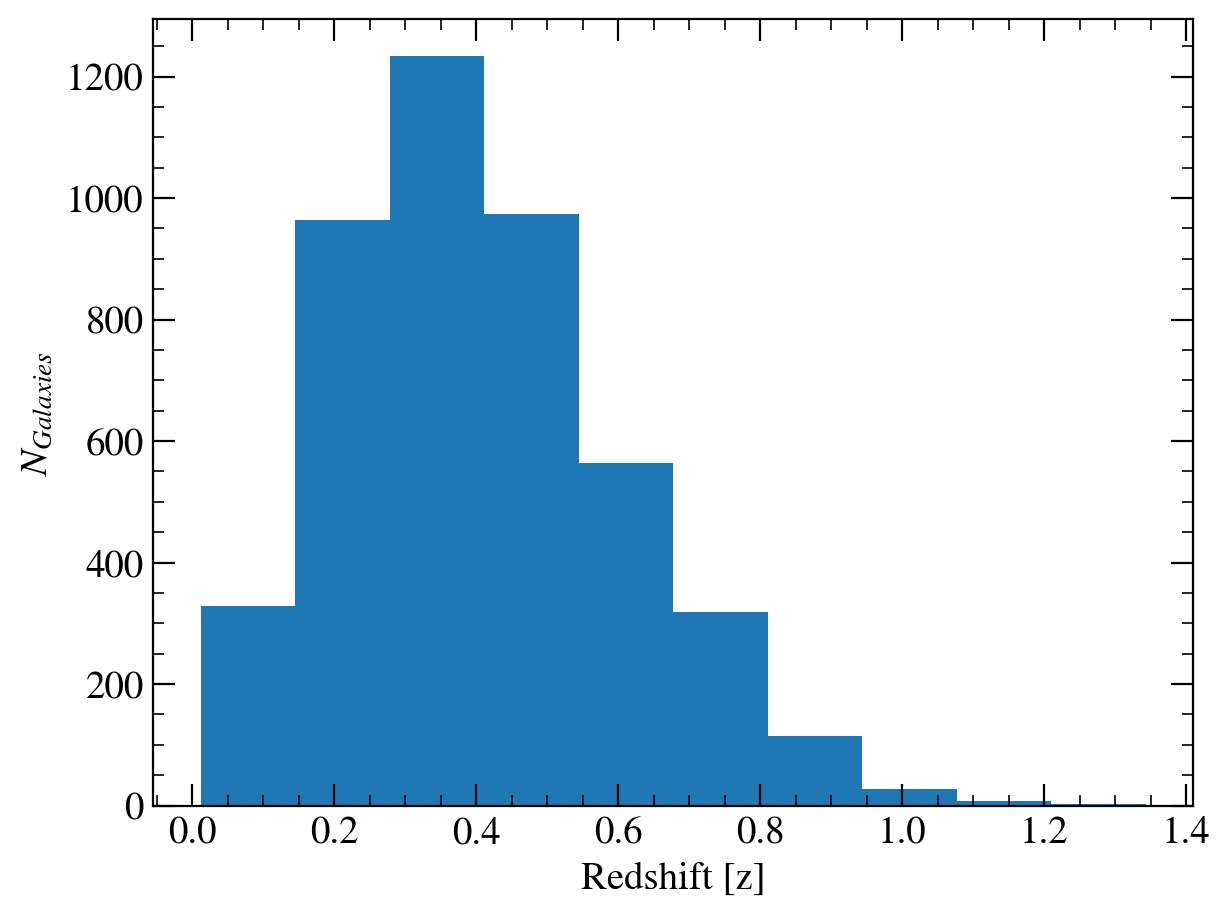

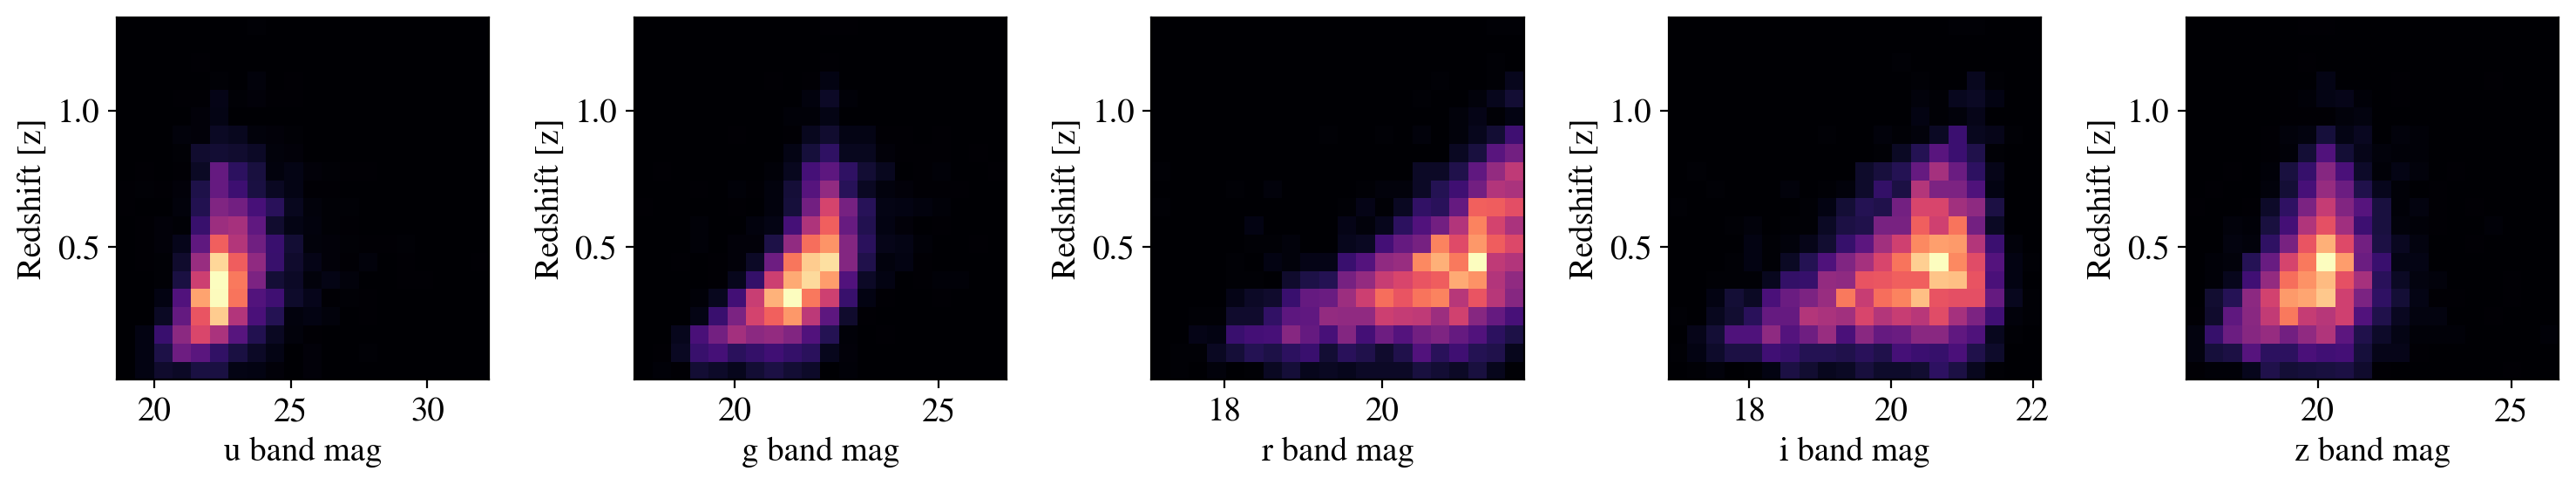

In [6]:
# regression
plt.hist(ydata, )
plt.xlabel("Redshift [z]")
plt.ylabel("$N_{Galaxies}$")
canvas_ticks(plt)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axs):
    ax.hist2d(xdata[:, i], ydata, bins=20, cmap='magma')
    ax.set_xlabel(f"{bands[i]} band mag")
    ax.set_ylabel("Redshift [z]")
fig.tight_layout()
plt.show()


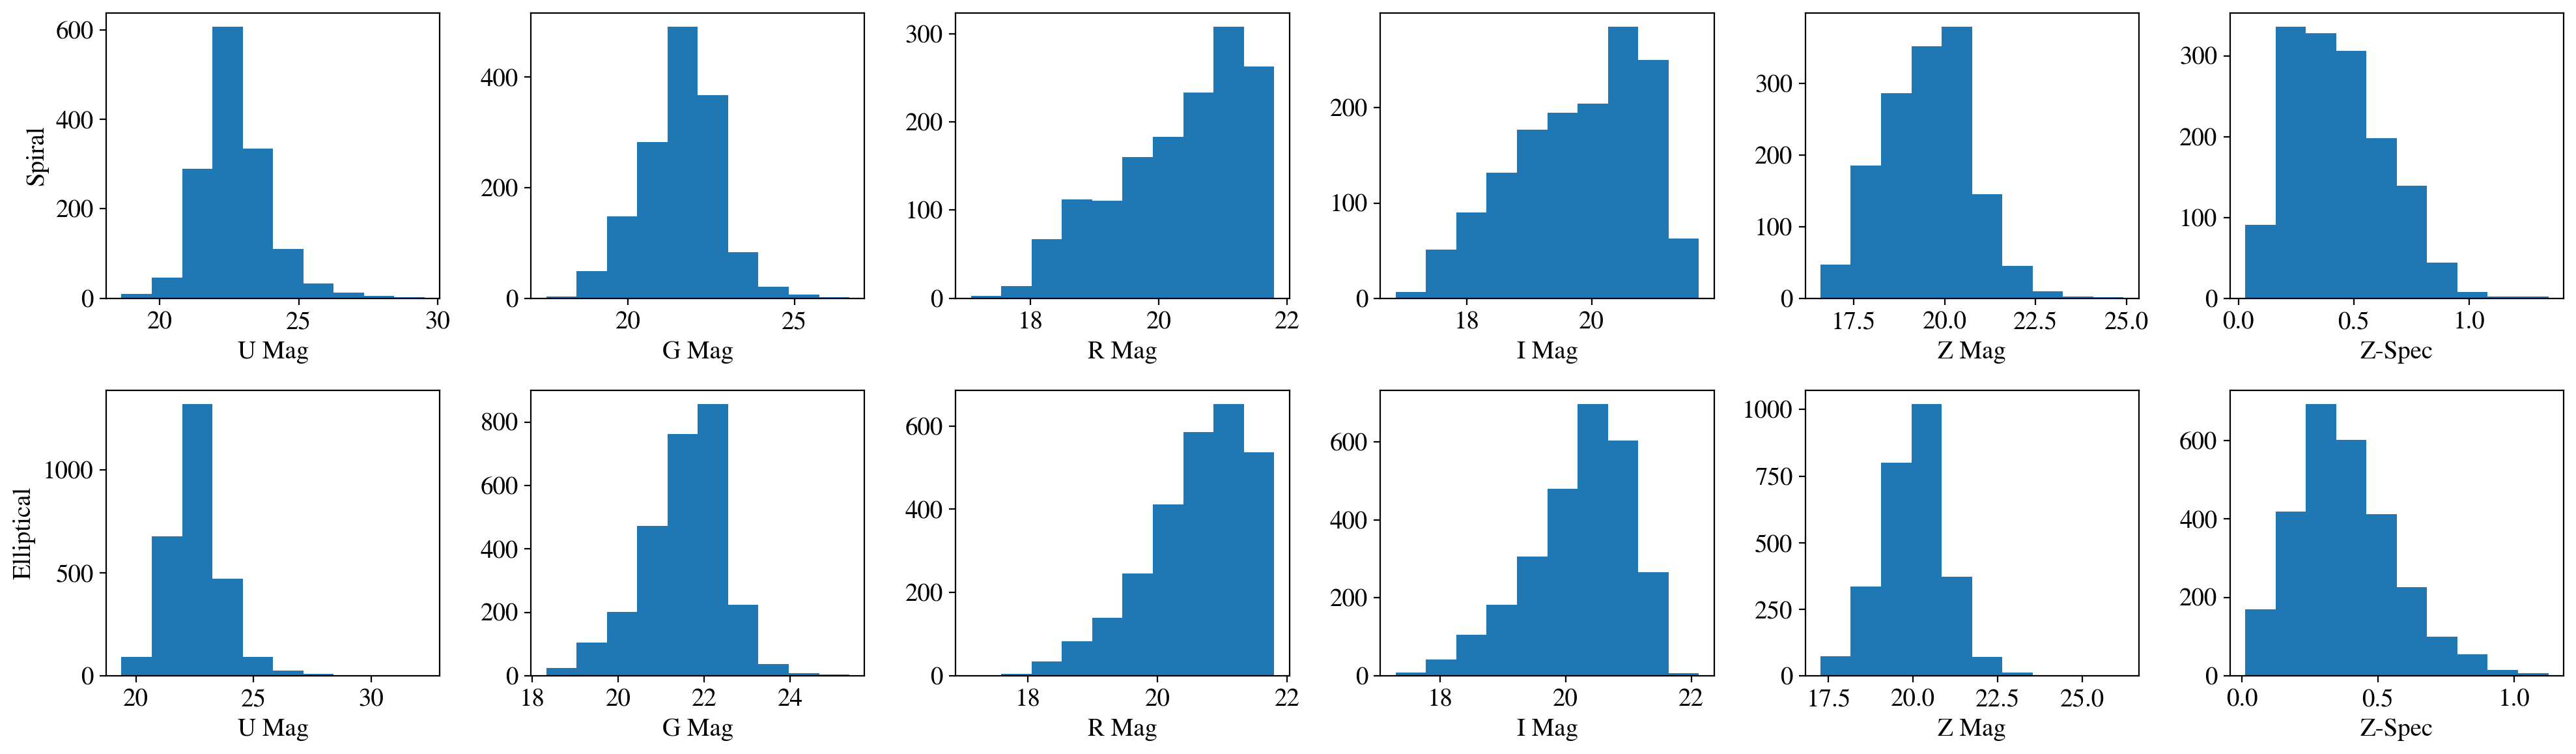

In [7]:
# classification
elliptical_indices = np.where(classes == -1)[0]
spiral_indices = np.where(classes == 1)[0]
names = ['U Mag', 'G Mag', "R Mag", "I Mag", "Z Mag", "Z-Spec"]

fig, axes = plt.subplots(2, 6, figsize=(20, 6))

for i, ax in enumerate(axes[0]):
    ax.hist(xxdata[spiral_indices, i])
    ax.set_xlabel(names[i])
    ax.set_ylabel("Spiral" if i == 0 else "")

for i, ax in enumerate(axes[1]):
    ax.hist(xxdata[elliptical_indices, i])
    ax.set_xlabel(names[i])
    ax.set_ylabel("Elliptical" if i == 0 else "")
fig.tight_layout()
plt.show()


<span style="color:blue"> <i> 2. Do the following preprocessing: </i></span> <br>

#####  Preprocessing:

- Next, split the sample into training data and the testing data. We will be using the training data to train different algorithms and then compare the performance over the testing data. In this project, keep 80% data as training data and uses the remaining 20% data for testing.  <br>
- Often, the data can be ordered in a specific manner, hence shuffle the data prior to splitting it into training and testing samples. <br>
- Many algorithms are also not scale invariant, and hence scale the data (different features to a uniform scale). All this comes under preprocessing the data.
http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing <br>
Use StandardScaler from sklearn (or write your own routine) to center the data to 0 mean and 1 variance. Note that you only center the training data and then use its mean and variance to scale the testing data before using it. <br><br>

Hint: How to get a scaled training data: <br>

1. Let the training data be: train = ("training X data", "training Y data")<br>
2. You can first define a StandardScaler: <br>
scale_xdata, scale_ydata = preprocessing.StandardScaler(), preprocessing.StandardScaler()<br>
3. Then, do the fit: <br>
for regression: scale_xdata.fit(train_regression[0]), scale_ydata.fit(train_regression[1].reshape(-1, 1))<br>
for classication: scale_xdata.fit(train_classification[0])<br>
  Here, no need to fit for y data for classification (it's either +1 or -1. Already scaled)<br>
4. Next, transform: <br>
 for regression: scaled_train_data = (scale_xdata.fit_transform(train_regression[0]), scale_ydata.fit_transform(train_regression[1].reshape(-1, 1)))<br>
 for classication: scaled_train_data = (scale_xdata.fit_transform(train_classification[0]), train_classification[1])<br>
 Again, y data is already scaled for classification.  <br>


Do this for test data as well.


In [8]:
from sklearn import preprocessing

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

# Regression Data
regression_indices = np.random.permutation(range(len(xdata[:, 0])))
X_data = xdata[regression_indices, :]
Y_data = ydata[regression_indices]

X_train_reg, X_test_reg, Y_train_reg, Y_test_reg = train_test_split(X_data, Y_data, train_size=0.8)

print("Regression Data:")
print("Training Set - X:", np.shape(X_train_reg), " Y:", np.shape(Y_train_reg))
print("Testing Set - X:", np.shape(X_test_reg), " Y:", np.shape(Y_test_reg))

# Classification Data
classification_indices = np.random.permutation(range(len(xxdata[:, 0])))
XX_data = xxdata[classification_indices, :]
YY_data = classes[classification_indices]

XX_train_cls, XX_test_cls, YY_train_cls, YY_test_cls = train_test_split(XX_data, YY_data, train_size=0.8)

print("\nClassification Data:")
print("Training Set - XX:", np.shape(XX_train_cls), " YY:", np.shape(YY_train_cls))
print("Testing Set - XX:", np.shape(XX_test_cls), " YY:", np.shape(YY_test_cls))


Regression Data:
Training Set - X: (3628, 5)  Y: (3628,)
Testing Set - X: (907, 5)  Y: (907,)

Classification Data:
Training Set - XX: (3317, 6)  YY: (3317,)
Testing Set - XX: (830, 6)  YY: (830,)


In [10]:
# Scale Regression Data
scale_x_reg, scale_y_reg = preprocessing.StandardScaler(), preprocessing.StandardScaler()
scale_x_reg.fit(X_train_reg)
scale_y_reg.fit(Y_train_reg.reshape(-1, 1))

scaled_train_data_regression = (
    scale_x_reg.transform(X_train_reg),
    scale_y_reg.transform(Y_train_reg.reshape(-1, 1))
)

scaled_test_data_regression = (
    scale_x_reg.transform(X_test_reg),
    scale_y_reg.transform(Y_test_reg.reshape(-1, 1))
)

# Classification Data
classification_indices = np.random.permutation(range(len(xxdata[:, 0])))
XX_data_cls = xxdata[classification_indices, :]
YY_data_cls = classes[classification_indices]

XX_train_cls, XX_test_cls, YY_train_cls, YY_test_cls = train_test_split(XX_data_cls, YY_data_cls, train_size=0.8)

# Scale Classification Data
scale_x_cls, scale_y_cls = preprocessing.StandardScaler(), preprocessing.StandardScaler()
scale_x_cls.fit(XX_train_cls)

scaled_train_data_classification = (
    scale_x_cls.transform(XX_train_cls),
    YY_train_cls
)

scaled_test_data_classification = (
    scale_x_cls.transform(XX_test_cls),
    YY_test_cls
)

##### Metrics

The last remaining preperatory step is to write metric for gauging the performance of the algorithm. Write a function to calculate the 'RMS' error given (y_predict, y_truth) to gauge regression and another function to evaluate accuracy of classification. <br>
In addition, for classification, we will also use confusion matrix.

Below is an example you can use. Feel free to write you own.

In [11]:
from sklearn.metrics import confusion_matrix

def rms(x, y, scale1=None, scale2=None):
    '''Calculate the rms error given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    if scale1 is not None:
        x= scale1.inverse_transform(x)
    if scale2 is not None:
        y = scale2.inverse_transform(y)
    return  np.sqrt(np.mean((x[mask] - y[mask]) ** 2))

def acc(x, y):
    '''Calculate the accuracy given the truth and the prediction
    '''
    mask = np.isfinite(x[:]) & np.isfinite(y[:])
    return  (x == y).sum()/x.size


#### Hyperparameter method

Now, we will be varying hyperparameters to get the best model and build some intuition. There are various ways to do this and we will use Grid Search methodology (as you did in Problem 1 and 2) which simply tries all the combinations along with some cross-validation scheme. For most part, we will use 4-fold cross validation. <br>
Sklearn provides GridSearchCV functionality for this purpose. <br>

Its recommended to spend some time to go through output format of GridSearchCV and write some utility functions to make the recurring plots for every parameter. <br>
Grid Search returns a dictionary with self explanatory keys for the most part. Mostly, the keys correspond to (masked) numpy arrays of size = #(all possible combination of parameters). The value of individual parameter in every combination is given in arrays with keys starting from 'param_\*' and this should help you to match the combination with the corresponding scores. <br>
For masked arrays, you can access the data values by using \*.data
<br>
<br>
*Do not overwrite these grid search-ed variables (and not only their result) since we will compare all the models together in the end*

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

<span style="color:red"><i> You can choose to do only one of the two classifiers: kNN or Random Forests.</i></span> <br>
<span style="color:red"><i> If you choose to do Method 2 (Random Forests), take a look at hints from Method 1 (kNN). </i></span> <br>

### <span style="color:red"> Option (1) </span>
### Method 1. k Nearest Neighbors

For regression, let us play with grid search using knn to tune hyperparmeters. (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) Consider the following 3 hyperparameters -
- Number of neighbors ([2, 3, 5, 10, 15, 20, 25, 50, 100])
- Weights of leaves (Uniform or Inverse Distance weighing)
- Distance metric (Eucledian or Manhattan distance - parameter 'p')

<span style="color:blue"> <i> 1. Do a grid search on these parameters. List the combination of hyperparameters you tried and evaluate the accuracy (mean test score) and its standard deviation. Which gives the highest accuracy value? </i></span> <br>

In [13]:
from sklearn.neighbors import KNeighborsRegressor

Hint: (Read the documentations carefully for more detail.)

First, define the hyperparameters: parameters = {'n_neighbors':[2, 3, 5, 10, 15, 20, 25, 50, 100], 'weights':['uniform', 'distance'], 'p':[1, 2]}

Specify the algorithm you want to use: e.g. knnr = KNeighborsRegressor()

Then, Do a grid search on these parameters using 4 fold cross validation: gcknn = GridSearchCV(knnr, parameters, cv=4)

Do the fit: gcknn.fit(*scaled_training_data)

(Let "scaled_training_data" be the training data where "scaled_training_data = ("train X data", "train Y data")"

Get results: $results = gcknn.cv_results_$

$cv_results_$ has the following dictionaries: "rank_test_score," "mean_test_score," "std_test_score," and "params" (See http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Then, you can evaluate the models based on "rank_test_score" and print out their "params," along with their "mean_test_score" and "std_test_score".

In [14]:
regression_parameters = {
    'n_neighbors': [2, 3, 5, 10, 15, 20, 25, 50, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()
grid_search_knn_regressor = GridSearchCV(knn_regressor, regression_parameters, cv=4)
grid_search_knn_regressor.fit(*scaled_train_data_regression)
regression_results = grid_search_knn_regressor.cv_results_

In [15]:
import pandas as pd

results_df = pd.DataFrame(regression_results)

max_index = np.argmax(results_df['mean_test_score'])

print(f"""
The highest accuracy was found with
\tmean_test_score = {results_df['mean_test_score'][max_index]}
\tstd_test_score = {results_df['std_test_score'][max_index]}.
The corresponding hyperparameters were {results_df['params'][max_index]}
""")


The highest accuracy was found with
	mean_test_score = 0.5612048400782181 
	std_test_score = 0.019631080233947218.
The corresponding hyperparameters were {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}



<span style="color:blue"> <i> 2. Also print out fitting and scoring times for all hyperparameter combinations. </i></span> <br>

*Plot timings for fitting and scoring*

Hint: Assume that you got results from: $results = gcknn.cv_results_$

Then, get the scoring time: results['mean_score_time']

and the fitting time: results['mean_fit_time']

In [16]:
time_df = results_df[['mean_score_time', 'mean_fit_time', 'params']]
time_df


,mean_score_time,mean_fit_time,params
0,0.017285,0.005354,"{'n_neighbors': 2, 'p': 1, 'weights': 'uniform'}"
1,0.016433,0.003401,"{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}"
2,0.010846,0.006516,"{'n_neighbors': 2, 'p': 2, 'weights': 'uniform'}"
3,0.014735,0.003482,"{'n_neighbors': 2, 'p': 2, 'weights': 'distance'}"
4,0.031330,0.005479,"{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}"
5,0.016133,0.003269,"{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}"
6,0.009079,0.003317,"{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}"
7,0.009480,0.003209,"{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}"
8,0.027157,0.004294,"{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}"
9,0.024184,0.006047,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"


<span style="color:blue"> <i> 3. Based on the results you obtained in Part 1 and 2, answer the following questions </i></span> <br>

- Is it always better to use more neighbors?
- Is it better to weigh the leaves, if yes, which distnace metric performs better?
- GridCV returns fitting and scoring time for every combination. You will find that scoring time is higher than training time. Why do you think is that the case?

##### Answer:



Not necessarily, theres a trade-off between computational time and model performance.

Using a larger number of neighbors results in increased fitting and scoring times. Regarding leaf weighting, the impact is more pronounced in mean_score_time than mean_fit_time, signifying that weighing leaves does improve efficiency.

Specifically, weighting by distance outperforms the uniform weighting approach. When using GridCV, the observed discrepancy between scoring and training times can be attributed to the scoring process, which involves the computation of more resource-intensive combinations for comparison. This disparity results in a longer duration for scoring compared to training.

<span style="color:blue"> <i> 4. Which parameters seem to affect the performance most? To better answer this question, make plots of the mean test score for each hyperparameter. </i></span> <br>

Hint:
Suppose you have two types of hyperparameters: A and B.
Let A = [1, 2] and B = [1, 2, 4, 7, 10].

Then, you have 20 different combination of hyperparameters.

Let A = 1. Then, you can try (A,B) = (1,1), (1,2), (1,4), (1,7), (1,10)
Suppose that the mean score you got for the above combination is [0.7, 0.72, 0.75, 0.77, 0.8].
Similarly, for A = 2, you tried (A,B) = (2,1), (2,2), (2,4), (2,7), (2,10) and obtaind the mean score of [0.8, 0.82, 0.85, 0.87, 0.9].

To better see how changing the value of paramter A affects the performance, you can make the following plot:

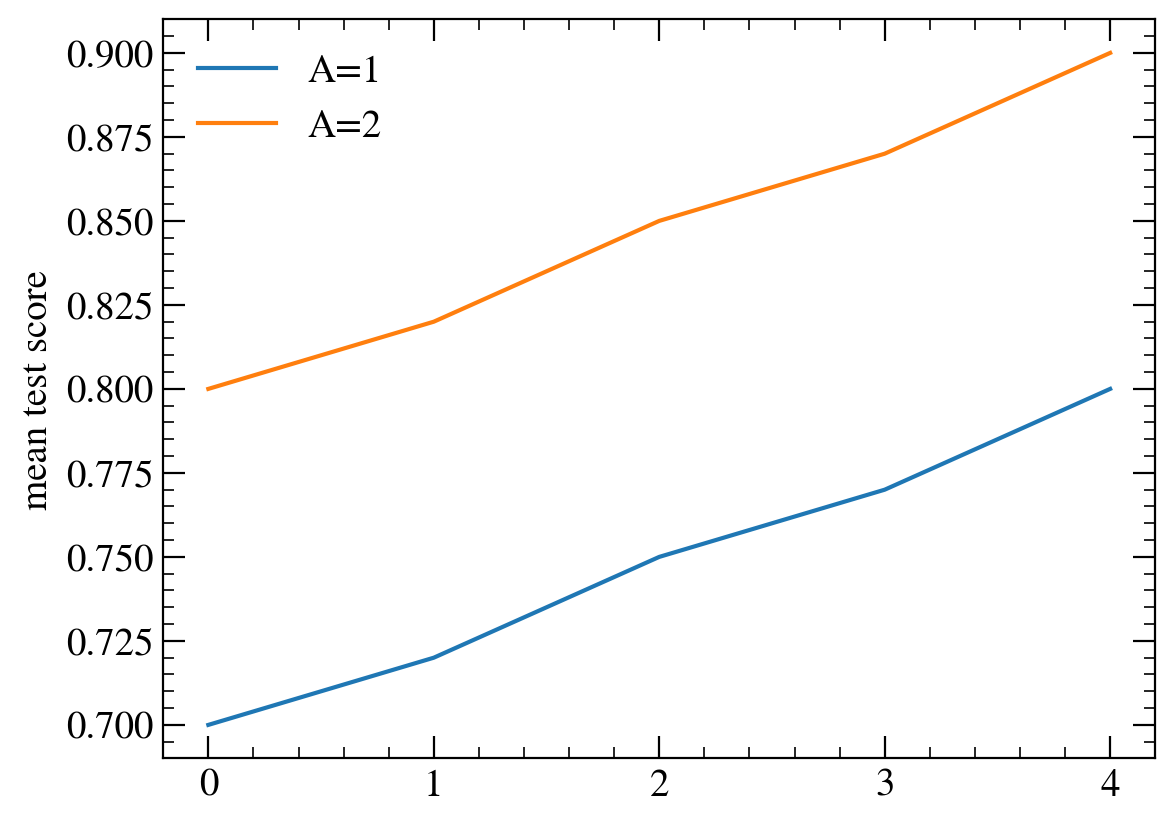

In [17]:
A_1 = [0.7, 0.72, 0.75, 0.77, 0.8]
A_2 = [0.8, 0.82, 0.85, 0.87, 0.9]

plt.plot(A_1, label = "A=1")
plt.plot(A_2, label = "A=2")
plt.ylabel("mean test score")
plt.legend(frameon = False)
canvas_ticks(plt)
plt.show()

This is the plot of the mean test score for A marginalizing over B.

Similarly, make a plot of the mean test score for each kNN hyperparameter.

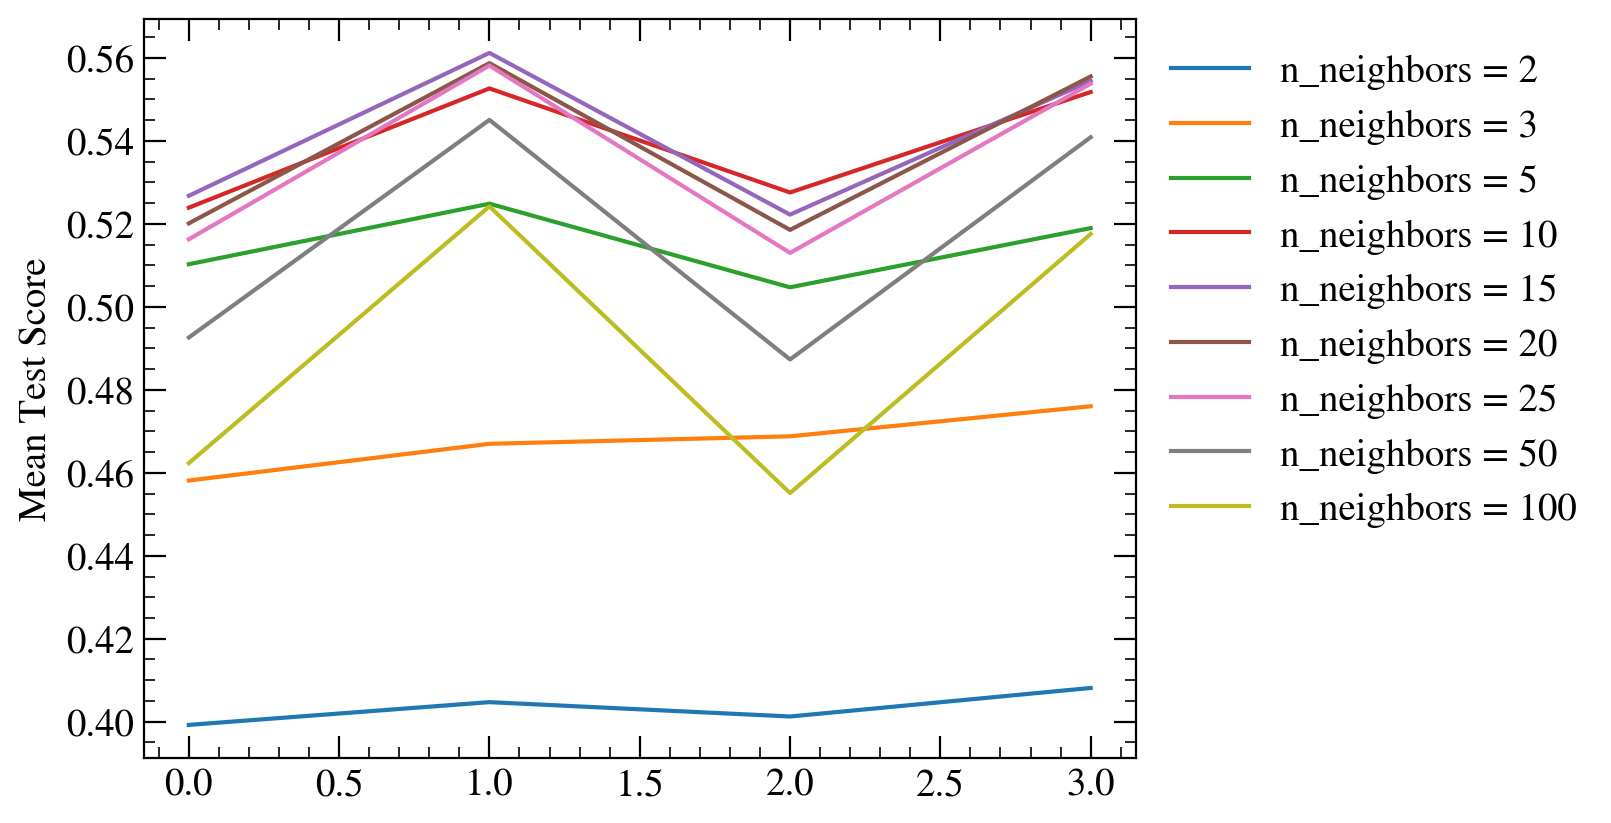

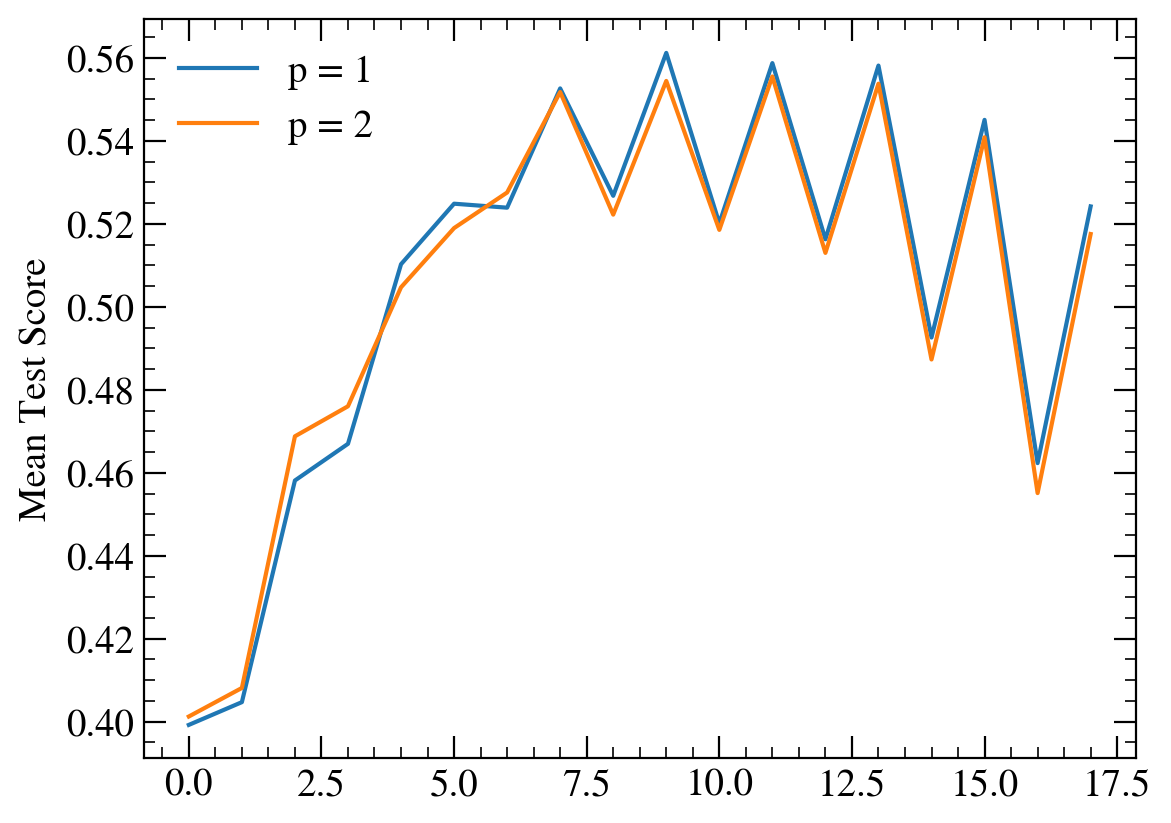

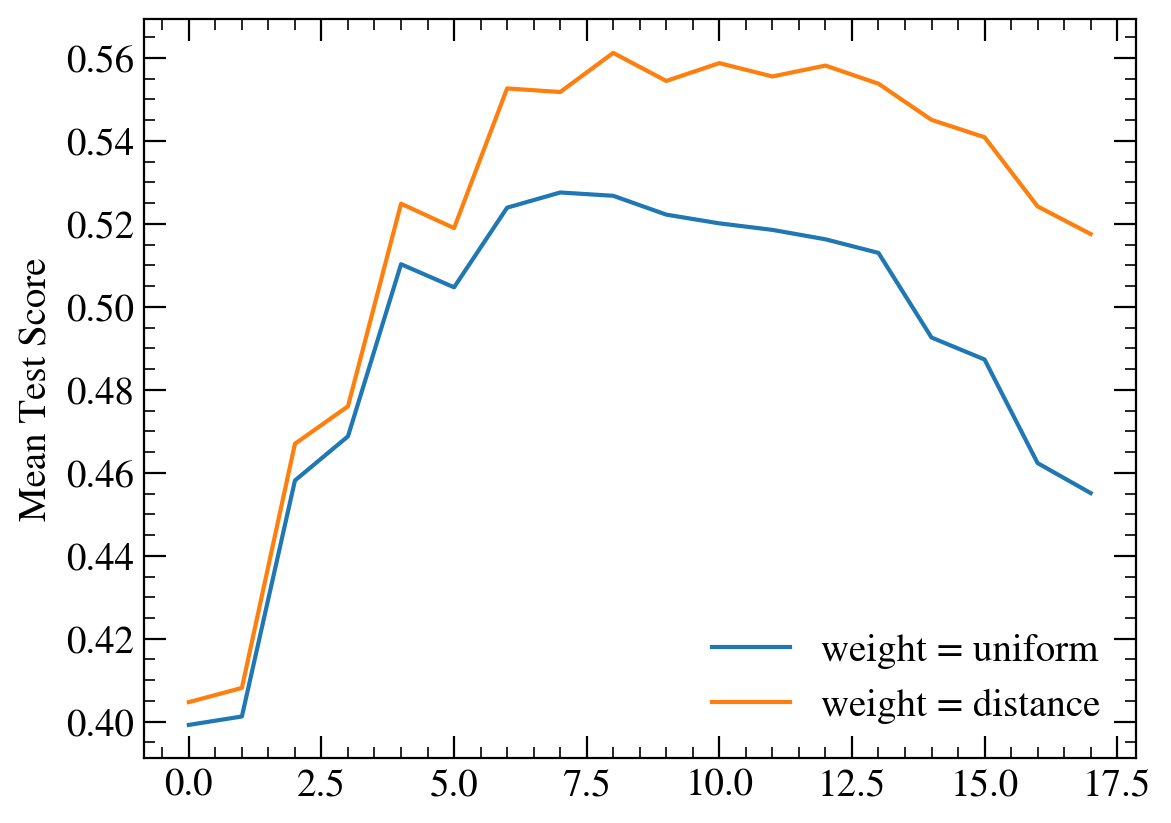

In [18]:

A = results_df['param_n_neighbors']
B = results_df['param_p']
C = results_df['param_weights']
means = results_df['mean_test_score']
data = np.array([means, A, B, C])
ns = np.unique(A)

# n_neighbors
plt.figure()
for n in ns:
    lab = 'n_neighbors = ' + str(n)
    plt.plot(np.array(range(len(means[np.where(data[1, :] == n)[0]]))),
             means[np.where(data[1, :] == n)[0]], label=lab)
plt.legend(frameon = False, bbox_to_anchor=[1, 1])
canvas_ticks(plt)
plt.ylabel("Mean Test Score")
plt.show()

# p
plt.figure()
plt.plot(np.array(range(len(means[np.where(data[2, :] == 1)[0]]))), means[np.where(data[2, :] == 1)[0]], label='p = 1')
plt.plot(np.array(range(len(means[np.where(data[2, :] == 2)[0]]))), means[np.where(data[2, :] == 2)[0]], label='p = 2')
plt.legend(frameon = False, )
canvas_ticks(plt)
plt.ylabel("Mean Test Score")
plt.show()

# weights
plt.figure()
plt.plot(np.array(range(len(means[np.where(data[3, :] == 'uniform')[0]]))),
         means[np.where(data[3, :] == 'uniform')[0]], label='weight = uniform')
plt.plot(np.array(range(len(means[np.where(data[3, :] == 'uniform')[0]]))),
         means[np.where(data[3, :] == 'distance')[0]], label='weight = distance')
plt.legend(frameon = False)
canvas_ticks(plt)
plt.ylabel("Mean Test Score")
plt.show()

<span style="color:blue"> <i> 5. You have determined the best combination of hyperparameters and CV schemes. Predict the test y data using the GridSearchCV method. Use the "rms" metric function we defined earlier and calculate the rms error on the test data.  </i></span> <br>

Hint: To determine the rms error, you need:

Truth: given from data (test_data[1]) <br>
Prediction: gridsearch.predict(test_data[0])
(https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)


In [19]:
pred = grid_search_knn_regressor.predict(scaled_test_data_regression[0])
truth = scaled_test_data_regression[1]
rms_regression = rms(pred,truth)

print(f"rms error: {rms_regression:.4f}")

rms error: 0.6443


#### Classification

In [20]:
from sklearn.neighbors import KNeighborsClassifier
# http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Here we will look at 4 different type of cross-validation schemes -
- Kfold
- Stratified Kfold
- Shuffle Split
- Stratified Shuffle Split

<span style="color:blue"> <i> 6. Assuming the list of hyperparameters from Part 1, do 4 different grid searches. From Part 1, take top 5 combination of hyperparameters which gives you the highest accuracy value. Rank the performance of CV schemes for each combination.  </i></span> <br>

In [21]:
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit

In [22]:
parameters = {'n_neighbors':[2, 3, 5, 10, 15, 20, 25, 50, 100], 'weights':['uniform', 'distance'], 'p':[1, 2]}
knnc = KNeighborsClassifier()

#Grid Search
gc = GridSearchCV(knnc, parameters, cv=KFold(4))
#Do the fit
gc.fit(*scaled_train_data_classification)

gc2 = GridSearchCV(knnc, parameters, cv=StratifiedKFold(4))
#Do the fit
gc2.fit(*scaled_train_data_classification)

gc3 = GridSearchCV(knnc, parameters, cv=ShuffleSplit(4))
#Do the fit
gc3.fit(*scaled_train_data_classification)

gc4 = GridSearchCV(knnc, parameters, cv=StratifiedShuffleSplit(4))
#Do the fit
gc4.fit(*scaled_train_data_classification)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=4, random_state=None, test_size=None,
            train_size=None),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 5, 10, 15, 20, 25, 50, 100],
                         'p': [1, 2], 'weights': ['uniform', 'distance']})

In [23]:
top5_idx = np.argsort(results_df['mean_test_score'])[-5:]
top5_val = np.sort(results_df['mean_test_score'])[-5:]
print("Index with the highest mean_test_score:", np.argmax(results_df['mean_test_score']))
top5_df = results_df['params'].iloc[top5_idx]
print(top5_df)

gc_df = pd.DataFrame(gc.cv_results_)
gc2_df = pd.DataFrame(gc2.cv_results_)
gc3_df = pd.DataFrame(gc3.cv_results_)
gc4_df = pd.DataFrame(gc4.cv_results_)

top_5 = list(top5_df)


mean_df = pd.DataFrame({'Original':top5_val, 'KFold':list(gc_df['mean_test_score'][top5_idx]),
 'Stratified KFold':list(gc2_df['mean_test_score'][top5_idx]),
 'Shuffle Split':list(gc3_df['mean_test_score'][top5_idx]),
 'Stratified Shuffle Split':list(gc4_df['mean_test_score'][top5_idx]), 'params':top_5})


std_df = pd.DataFrame({'Original':list(results_df['std_test_score'][top5_idx]), 'KFold':list(gc_df['std_test_score'][top5_idx]),
 'Stratified KFold':list(gc2_df['std_test_score'][top5_idx]),
 'Shuffle Split':list(gc3_df['std_test_score'][top5_idx]),
 'Stratified Shuffle Split':list(gc4_df['std_test_score'][top5_idx]), 'params':top_5})

Index with the highest mean_test_score: 17
19    {'n_neighbors': 15, 'p': 2, 'weights': 'distan...
23    {'n_neighbors': 20, 'p': 2, 'weights': 'distan...
25    {'n_neighbors': 25, 'p': 1, 'weights': 'distan...
21    {'n_neighbors': 20, 'p': 1, 'weights': 'distan...
17    {'n_neighbors': 15, 'p': 1, 'weights': 'distan...
Name: params, dtype: object


In [24]:
print("Mean Test Score")
mean_df


Mean Test Score


,Original,KFold,Stratified KFold,Shuffle Split,Stratified Shuffle Split,params
0,0.554445,0.743749,0.746159,0.756024,0.732681,"{'n_neighbors': 15, 'p': 2, 'weights': 'distan..."
1,0.555524,0.746158,0.748870,0.752259,0.737952,"{'n_neighbors': 20, 'p': 2, 'weights': 'distan..."
2,0.558152,0.750079,0.750680,0.754518,0.736446,"{'n_neighbors': 25, 'p': 1, 'weights': 'distan..."
3,0.558743,0.749175,0.750380,0.759789,0.737952,"{'n_neighbors': 20, 'p': 1, 'weights': 'distan..."
4,0.561205,0.748270,0.746458,0.756777,0.739458,"{'n_neighbors': 15, 'p': 1, 'weights': 'distan..."


In [25]:
print("Std Test Score")
std_df

Std Test Score


,Original,KFold,Stratified KFold,Shuffle Split,Stratified Shuffle Split,params
0,0.023449,0.019392,0.010103,0.027524,0.010075,"{'n_neighbors': 15, 'p': 2, 'weights': 'distan..."
1,0.022842,0.015914,0.011482,0.028205,0.009284,"{'n_neighbors': 20, 'p': 2, 'weights': 'distan..."
2,0.022147,0.016684,0.007879,0.025246,0.011568,"{'n_neighbors': 25, 'p': 1, 'weights': 'distan..."
3,0.020476,0.015278,0.009065,0.025768,0.011858,"{'n_neighbors': 20, 'p': 1, 'weights': 'distan..."
4,0.019631,0.017763,0.007235,0.019564,0.013215,"{'n_neighbors': 15, 'p': 1, 'weights': 'distan..."


<span style="color:blue"> <i> 7. Answer the following questions: </i></span> <br>

- Are the conclusions different for any parameter from the regression case?
- Does the mean accuracy change for different CV scheme?
- Does the standard deviation in mean accuracy change?

##### Answer:
We observe that the most effective cross-validation scheme is the stratified shuffle split, although the its not substantial. Across all CV schemes, the outcomes for both mean and standard deviation test scores are very similar, with a somewhat larger discrepancy in std compared to the mean. Overall, it is I saw that setting n_neighbors to 20 or 15 is optimal, with the choice of p having little impact as it is evenly distributed between 1 and 2. Moreover, it is apparent that weighting by distance yields optimal results. This means the conclusions remain largely consistent with those drawn from the regression case based on the parameters. Although there is a slight variance in both mean and std accuracy, the differences are not that big.

<span style="color:blue"> <i> 8. Using the best combination of hyperparameters and CV schemes you have found, compute the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and evaluate the accuracy.  </i></span> <br>

Hint: To get a confusion matrix, you need both truth (available from data) and prediction (can be computed using .predict function from GridSearchCV (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Classification model
	Accuracy = 0.753


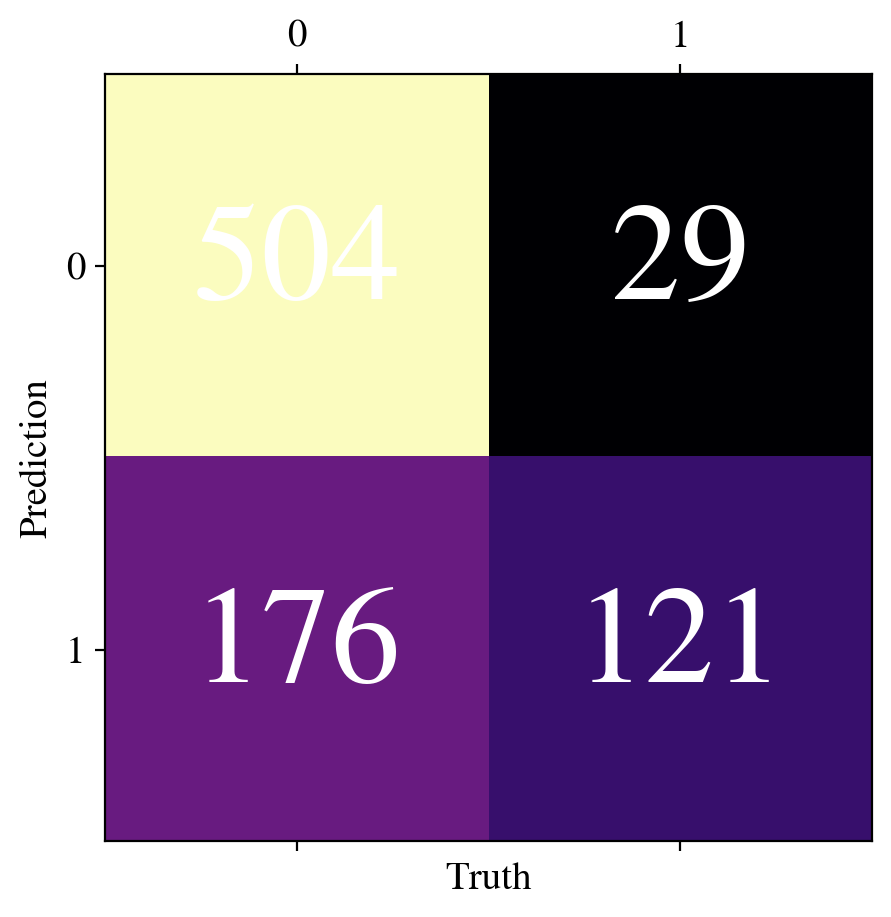

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

predictions = gc3.predict(scaled_test_data_classification[0])
truth = scaled_test_data_classification[1]

# Compute confusion matrix and accuracy
confusion = confusion_matrix(y_true=truth, y_pred=predictions)
accuracy = accuracy_score(truth, predictions)

# Plotting the confusion matrix
fig, ax = plt.subplots()

im = ax.matshow(confusion, cmap='magma')

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, confusion[i, j],
                       ha="center", va="center", color="w", fontsize=50)

ax.set_xlabel("Truth")
ax.set_ylabel("Prediction")
fig.tight_layout()

# Display accuracy
print("Classification model")
print(f"\tAccuracy = {accuracy:.3f}")

In [37]:
!jupyter nbconvert --to html "/content/drive/MyDrive/P188_288/P188_288_Project3/Project3_188_Q4.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/P188_288/P188_288_Project3/Project3_188_Q4.ipynb to html
[NbConvertApp] Writing 1759589 bytes to /content/drive/MyDrive/P188_288/P188_288_Project3/Project3_188_Q4.html


### <span style="color:red"> Option (2) </span>
### Method 2. Random Forests

The most important feature of the random forest is the number of trees in the ensemble. We will also play with the maximum depth of the trees.

Try:<br>
n_estimators = [10, 50, 150, 200, 300]<br>
max_depth = [10, 50, 100]<br>

In [28]:
from sklearn.ensemble import RandomForestRegressor
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

<span style="color:blue"> <i> 1. Do the grid search over n_estimators and max_depth. List the combination of hyperparameters you tried and evaluate the accuracy (mean test score) and its standard deviation. Which gives the highest accuracy value?  </i></span> <br>


In [29]:
rf = RandomForestRegressor()
parameters = ...

gcrf = GridSearchCV(rf, parameters, cv=5)

...

Ellipsis

<span style="color:blue"> <i> 2. Which parameters seem to affect the performance most? To better answer this question, make plots of the mean test score for each hyperparameter. (plot the mean test score of n_estimators marginalizing over max_depth, etc) </i></span> <br>

In [30]:
...

Ellipsis

<span style="color:blue"> <i> 3. Based on the results you obtained in Part 1, answer the following questions: </i></span> <br>

- Are the scores of these models statistically different? Based on this, which architecture will you choose for your model?
- For every parameter, make the plot for fitting time. Based on this and the previous question, how many trees do you recommend keeping in the ensemble?

In [31]:
...

Ellipsis

##### Answer:


<span style="color:blue"> <i> 4. You have determined the best combination of hyperparameters. Predict the test y data using the GridSearchCV method. Use the "rms" metric function we defined earlier and calculate the rms error on the test data.  </i></span> <br>

In [32]:
...

Ellipsis

#### Classification



In [33]:
from sklearn.ensemble import RandomForestClassifier
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [34]:
#Grid search (This will take few minutes)

rfc = RandomForestClassifier()
parameters = ...

gcrfc = GridSearchCV(rfc, parameters, cv=StratifiedShuffleSplit(4, test_size=0.1, random_state = 100))

...

Ellipsis

<span style="color:blue"> <i> 5. Assuming the list of hyperparameters from Part 1, do the grid search using StratifiedShuffleSplit CV scheme. List the combination of hyperparameters you tried and evaluate the accuracy (mean test score) and its standard deviation. Which gives the highest accuracy value?  </i></span> <br>

In [35]:
...

Ellipsis

<span style="color:blue"> <i> 6. Using the best combination of hyperparameters, compute the confusion matrix (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and evaluate the accuracy.  </i></span> <br>

In [36]:
...

Ellipsis